<a href="https://colab.research.google.com/github/andreadosi1986/PrismaSVDUNet/blob/master/ProgettoCariocaEsaCustomDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install segmentation_models
!pip install rasterio
!pip install fiona

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 5.2 MB/s 


In [ ]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib.animation as animation
from matplotlib import rc
import rasterio
from rasterio import mask
import fiona
import skimage
from skimage.measure import regionprops
import random
import pandas as pd
from skimage import filters
import patchify
import tifffile as tiff
import tensorflow as tf
import keras
from scipy.ndimage import rotate
import fiona
from rasterio.plot import reshape_as_image
import tensorflow.keras.utils

In [ ]:
brazil_mask = np.load('/content/drive/MyDrive/datamining/prisma/Brazil/BrazilGtEsa4Classes.npy')
brazil_image = np.load('/content/drive/MyDrive/datamining/prisma/Brazil/BrazilPrismaImage.npy')

In [ ]:
print(np.max(brazil_image), np.min(brazil_image))

0.9536503 0.0


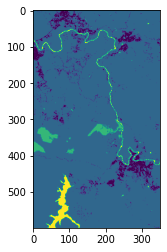

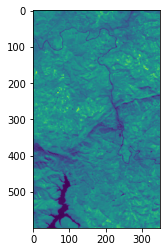

[0 1 2 3] (950, 950, 181) (950, 950)


In [ ]:
plt.imshow(brazil_mask[0:600, 250:600])
plt.show()
plt.imshow(brazil_image[0:600, 250:600, 50])
plt.show()
#the value of the mask: 0 build up, 1 vegetations, 2 mining area, 3 water
print(np.unique(brazil_mask), brazil_image.shape, brazil_mask.shape)

In [ ]:
### Brazilian Area: take a specific area of the image for training and build the patches ####

In [ ]:
###### TAKE THE SARDINIA PART BEFORE ######

In [ ]:
print(brazil_image.shape)

(950, 950, 181)


In [ ]:
#TOTAL SARDINIA CUBE
sardinia_array = rasterio.open('/content/drive/MyDrive/datamining/prisma/Brazil/PRS_L2C_STD_20210715102524_20210715102528_0001_FULLNew.tif').read()

In [ ]:
### Function to remove noise bands (systematic by prisma)
#CUTS: FROM 1,317 to 1,533 nm and FROM 1,784 to 2,035 nm"
def filter(numpy_cube):
    numpy_cube_cut1 = numpy_cube[0:96]
    numpy_cube_cut2 = numpy_cube[117:141]
    numpy_cube_cut3 = numpy_cube[170:232]
    numpy_cube_cut = np.concatenate((numpy_cube_cut1, numpy_cube_cut2, numpy_cube_cut3), axis=0)

    return numpy_cube_cut

In [ ]:
sardinia_array_filt = filter(sardinia_array)
print(sardinia_array_filt.shape)

(181, 1249, 1267)


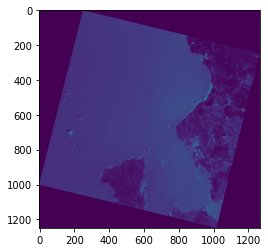

In [ ]:
plt.imshow(sardinia_array_filt[4,:,:])
plt.show()

In [ ]:
#the pixels having value more than 1 are the black stripes 
np.max(sardinia_array_filt)

1.7733107

In [ ]:
#STRAIGHTENING AND OPTIMIZING ALL THE IMAGES IN THE CUBE 
bands = sardinia_array_filt.shape[0]
lst=[]
for i in range (bands):
  rotate_cube = rotate(sardinia_array_filt[i,:,:], angle=14.1, reshape=False, order=0)
  lst.append(rotate_cube)
temp_sardinia_cube = np.array(lst)
temp_sardinia_reshape = reshape_as_image(temp_sardinia_cube)



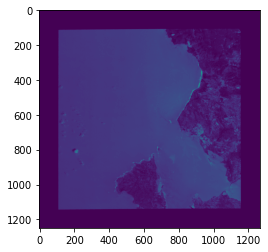

In [ ]:
plt.imshow(temp_sardinia_reshape[:,:,4])
plt.show()

In [ ]:
#cut the black stripes on the boundary
final_sardinia_array = temp_sardinia_reshape[150:1100, 150:1100, :]

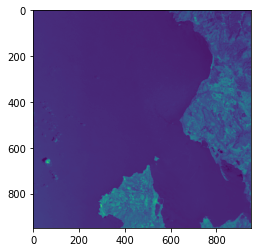

In [ ]:
plt.imshow(final_sardinia_array[:,:,100])
plt.show()

In [ ]:
#after cutting the black stripes, the max pixel value is less than 1 (correct!)
print(np.max(final_sardinia_array), np.min(final_sardinia_array))

0.7305246 0.0


In [ ]:
#the sardinia mask with 4 value (0 = build up, 1 = vegetations, 2 = mining area, 3 = water)
sardinia_mask = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/sardiniaMaskEsa4Classes.npy')

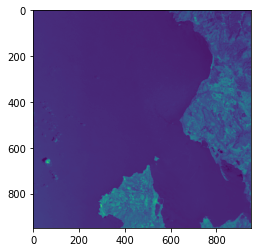

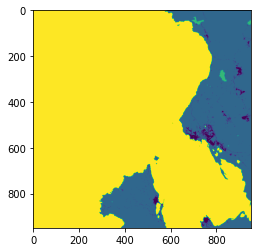

(950, 950, 181) (950, 950) [0 1 2 3]


In [ ]:
plt.imshow(final_sardinia_array[:,:,100])
plt.show()
plt.imshow(sardinia_mask)
plt.show()
print(final_sardinia_array.shape, sardinia_mask.shape, np.unique(sardinia_mask))

In [ ]:
## cut the unuseful area
sardinia_cut = final_sardinia_array[:600, 600:]
sardinia_mask_cut = sardinia_mask[:600, 600:]

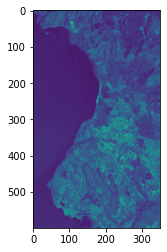

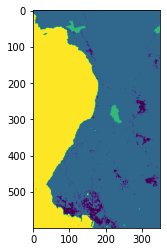

(600, 350, 181) (600, 350) [0 1 2 3]


In [ ]:
plt.imshow(sardinia_cut[:,:,100])
plt.show()
plt.imshow(sardinia_mask_cut)
plt.show()
print(sardinia_cut.shape, sardinia_mask_cut.shape, np.unique(sardinia_mask_cut))

In [ ]:
brazil_mask_cut = brazil_mask[0:600, 250:600]
brazil_cut = brazil_image[0:600, 250:600]
print(brazil_mask_cut.shape, brazil_cut.shape, np.unique(brazil_mask_cut))
print(np.max(brazil_cut))


(600, 350) (600, 350, 181) [0 1 2 3]
0.7797909


In [ ]:
# #concatenate the sardinia and brazil images
# final_image = np.concatenate((sardinia_cut, brazil_cut), axis = 1)
# final_mask = np.concatenate((sardinia_mask_cut, brazil_mask_cut), axis = 1)
# print(final_image.shape, final_mask.shape) 

(600, 700, 181) (600, 700)


In [ ]:
final_image = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/FinalCustomImage.npy')
final_mask = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/FinalCustomMask.npy')

In [ ]:
print(np.max(final_image), np.min(final_image))

0.7797909 0.0


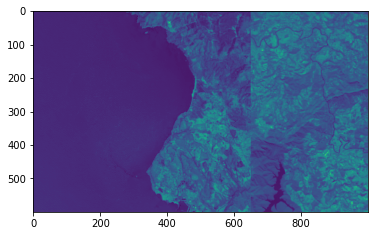

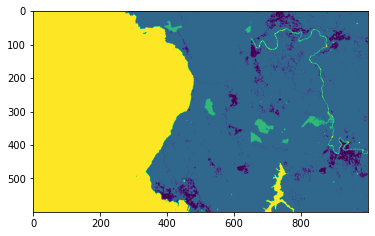

In [ ]:
plt.imshow(final_image[:,:,100])
plt.show()
plt.imshow(final_mask)
plt.show()

In [ ]:
####### APPLY THE SVD TO THE FULL IMAGE #######

In [ ]:
#build the 2d array for svd
svd_cube = np.reshape(final_image, (final_image.shape[0]*final_image.shape[1], final_image.shape[2]))
svd_cube.shape

(600000, 181)

In [ ]:
#SVD application
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=3)
svd.fit(svd_cube)
total_transf_cube = svd.transform(svd_cube)

In [ ]:
import pickle
filename = '/content/drive/MyDrive/datamining/prisma/Sardinia/SvdFullCustomImageSea.sav'
pickle.dump(svd, open(filename, 'wb'))

In [ ]:
print(np.min(total_transf_cube), np.max(total_transf_cube), ", the shape is ", total_transf_cube.shape )

-0.9273411 5.7797713 , the shape is  (600000, 3)


In [ ]:
#normalize from 0 to 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(total_transf_cube)
total_transf_cube_scaled = scaler.transform(total_transf_cube)

In [ ]:
print(np.min(total_transf_cube_scaled), np.max(total_transf_cube_scaled), total_transf_cube_scaled.shape)

0.0 1.0000001 (600000, 3)


In [ ]:
filename_norm = '/content/drive/MyDrive/datamining/prisma/Sardinia/NormalizaFullCustomImageSea.sav'
pickle.dump(scaler, open(filename_norm, 'wb'))

In [ ]:
#after the svd transformation, reshape the array as an 2D image 
svd_array_norm = np.reshape(total_transf_cube_scaled, (final_image.shape[0],final_image.shape[1],total_transf_cube_scaled.shape[1]))

In [ ]:
print(svd_array_norm.shape)

(600, 1000, 3)


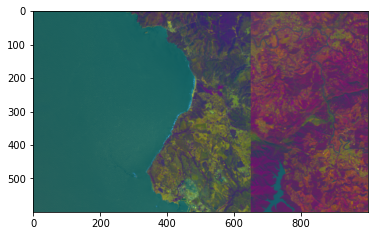

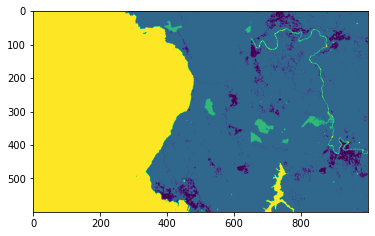

In [ ]:
plt.imshow(svd_array_norm)
plt.show()
plt.imshow(final_mask)
plt.show()

In [ ]:
#np.save('/content/drive/MyDrive/datamining/prisma/Sardinia/CustomImageSvdEsa', svd_array_norm)
#np.save('/content/drive/MyDrive/datamining/prisma/Sardinia/CustomMaskEsa', final_mask)

In [ ]:
####### PATCHES AND DATA AUGMENTATION ##############

In [ ]:
image_patches = patchify.patchify(svd_array_norm, (128,128,3), 25)

mask_patches = patchify.patchify(final_mask, (128,128), 25)

In [ ]:
#reshape patches in a 3d array
patches_res = image_patches.reshape(image_patches.shape[0] * image_patches.shape[1], image_patches.shape[3], image_patches.shape[4], image_patches.shape[5])
patches_mask_res = mask_patches.reshape(mask_patches.shape[0] * mask_patches.shape[1], mask_patches.shape[2], mask_patches.shape[3])

In [ ]:
print(np.unique(patches_mask_res), patches_mask_res.shape, patches_res.shape)

[0 1 2 3] (665, 128, 128) (665, 128, 128, 3)


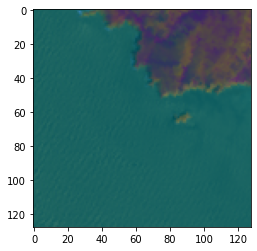

(128, 128, 3)


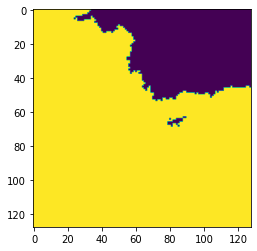

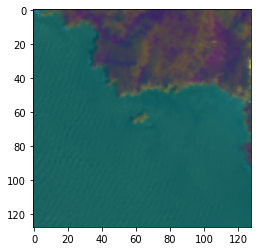

(128, 128, 3)


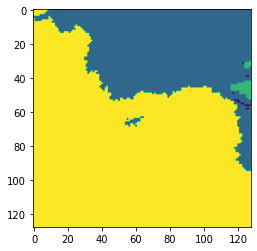

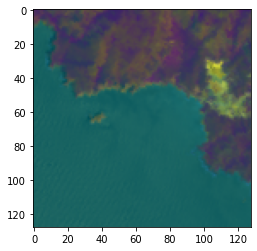

(128, 128, 3)


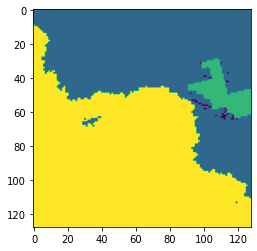

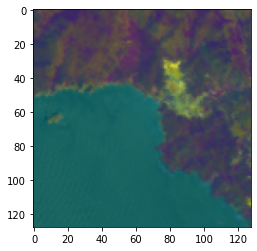

(128, 128, 3)


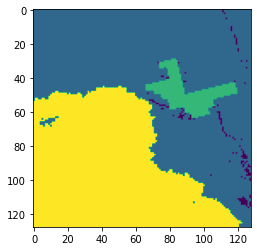

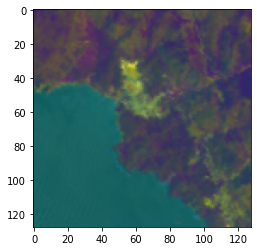

(128, 128, 3)


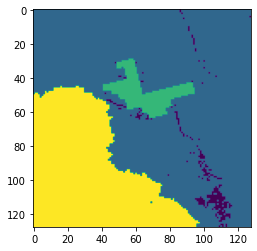

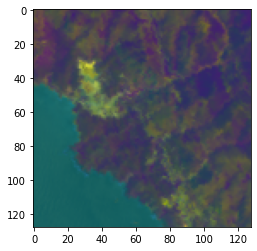

(128, 128, 3)


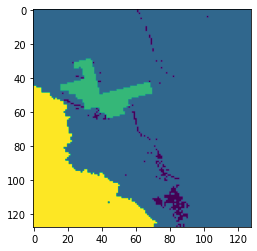

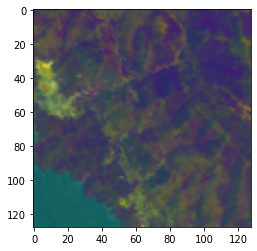

(128, 128, 3)


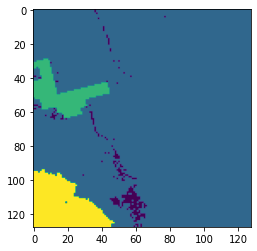

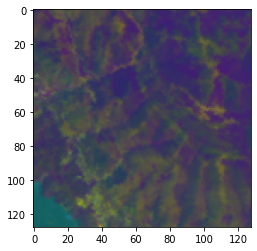

(128, 128, 3)


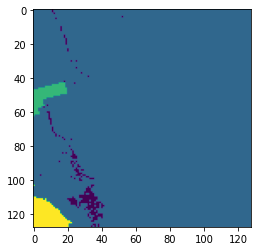

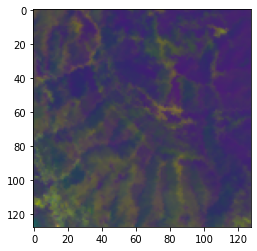

(128, 128, 3)


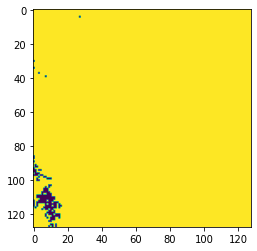

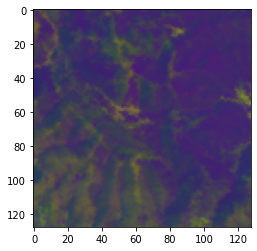

(128, 128, 3)


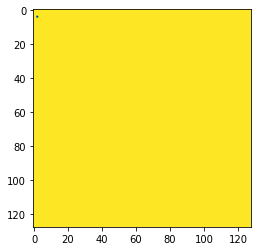

In [ ]:
#check if the picture and the mask are the same 
for i in range (10,20):
  plt.imshow(patches_res[i])
  plt.show()
  print(patches_res[i].shape) 
  plt.imshow(patches_mask_res[i])
  plt.show() 

In [ ]:
# Make sure the order of the spline interpolation is 0, default is 3. 
#With interpolation, the pixel values get messed up.
def rotation(image, seed):
    random.seed(seed)
    angle= random.randint(-180,180)
    r_img = rotate(image, angle, mode='reflect', reshape=False, order=0)
    return r_img

def h_flip(image, seed):
    random.seed(seed)
    hflipped_img= np.fliplr(image)
    return  hflipped_img

def v_flip(image, seed):
    random.seed(seed)
    vflipped_img= np.flipud(image)
    return vflipped_img

def v_transl(image, seed):
    random.seed(seed)
    n_pixels = random.randint(-64,64)
    vtranslated_img = np.roll(image, n_pixels, axis=0)
    return vtranslated_img

def h_transl(image, seed):
    random.seed(seed)
    n_pixels = random.randint(-64,64)
    htranslated_img = np.roll(image, n_pixels, axis=1)
    return htranslated_img

In [ ]:
######  custom data augmentation  #######

lst_temp = list(patches_res)
lst_temp_mask = list(patches_mask_res)

for i in range (patches_res.shape[0]):
  patches_res_i = patches_res[i,:,:]
  patches_mask_res_i = patches_mask_res[i,:,:]

  lst_temp.extend((rotation(patches_res_i, i), h_flip(patches_res_i, i), v_flip(patches_res_i, i), v_transl(patches_res_i, i), h_transl(patches_res_i, i)))
  lst_temp_mask.extend((rotation(patches_mask_res_i, i), h_flip(patches_mask_res_i, i), v_flip(patches_mask_res_i, i), v_transl(patches_mask_res_i, i), h_transl(patches_mask_res_i, i)))

patches_res = np.array(lst_temp)
patches_mask_res = np.array(lst_temp_mask)

In [ ]:
print(patches_res.shape, patches_mask_res.shape)

(3990, 128, 128, 3) (3990, 128, 128)


In [ ]:
#SECOND DATA AUGMENTATION: ADD RANDOM NOICE ONLY TO THE PATCHES WITH MINING AREA. THEN FLIP, TRANSLATE ECC...

temp_lst_noise = list(patches_res)
temp_lst_mask = list(patches_mask_res)
num = 2
for i in range (len(patches_res)):
  if num in temp_lst_mask[i]:
    mu = np.mean(patches_res[i,:,:])
    noise = np.random.normal(mu, 0.0015, (patches_res[i,:,:].shape[0], patches_res[i,:,:].shape[1], patches_res[i,:,:].shape[2]))
    patches_noise_i = noise + temp_lst_noise[i]
    patches_noise_i = temp_lst_noise[i]

    patches_mask_res_i = temp_lst_mask[i]
    temp_lst_noise.extend((patches_noise_i,rotation(patches_noise_i, i), h_flip(patches_noise_i, i), v_flip(patches_noise_i, i), v_transl(patches_noise_i, i), h_transl(patches_noise_i, i)))
    temp_lst_mask.extend((patches_mask_res_i,rotation(patches_mask_res_i, i), h_flip(patches_mask_res_i, i), v_flip(patches_mask_res_i, i), v_transl(patches_mask_res_i, i), h_transl(patches_mask_res_i, i)))


In [ ]:
#check how many patches with mining area
mining_pixel = 2
n = 0
index_of_mining = []
for i in range (len(temp_lst_noise)):
  if mining_pixel in temp_lst_mask[i]:
    n=n+1
    index_of_mining.append(i)
print("the patches with mining are", n, ", the percentage is", n/len(temp_lst_mask)*100,"%")

the patches with mining are 7667 , the percentage is 72.23478424722065 %


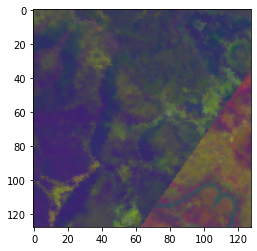

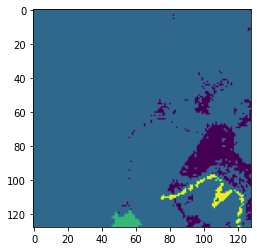

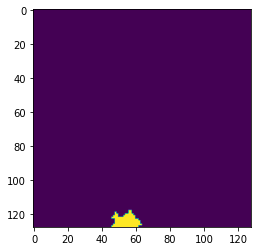

In [ ]:
#check if all the augmented patches having mining pixels have really mining pixels
import random
i = random.randint(0, len(index_of_mining))
j = index_of_mining[i]
plt.imshow(temp_lst_noise[j])
plt.show()
plt.imshow(temp_lst_mask[j])
plt.show()
#check if the mining areas exixt
plt.imshow(temp_lst_mask[j]==2)
plt.show()

In [ ]:
#THIRD DATA AUGMENTATION: Augment ONLY TO THE PATCHES WITH MINING AREA. 

#temp_lst_noise = list(patches_res)
#temp_list_image = list(patches_res)
#temp_lst_mask = list(patches_mask_res)
temp_list_image = temp_lst_noise

num = 2
for i in range (len(patches_res)):
  if num in temp_lst_mask[i]:
    #mu = np.mean(patches_res[i,:,:])
    #noise = np.random.normal(mu, 0.025, (patches_res[i,:,:].shape[0], patches_res[i,:,:].shape[1]))
    #patches_noise_i = noise + temp_lst_noise[i]
    patches_i = temp_list_image[i]
    patches_mask_res_i = temp_lst_mask[i]
    temp_list_image.extend((patches_i,rotation(patches_i, i), h_flip(patches_i, i), v_flip(patches_i, i), v_transl(patches_i, i), h_transl(patches_i, i)))
    temp_lst_mask.extend((patches_mask_res_i,rotation(patches_mask_res_i, i), h_flip(patches_mask_res_i, i), v_flip(patches_mask_res_i, i), v_transl(patches_mask_res_i, i), h_transl(patches_mask_res_i, i)))


In [ ]:
#check how many patches with pixel area
mining_pixel = 2
n = 0
index_of_mining = []
for i in range (len(temp_lst_noise)):
  if mining_pixel in temp_lst_mask[i]:
    n=n+1
    index_of_mining.append(i)
print("the patches with mining are", n, ", the percentage is", n/len(temp_lst_mask)*100,"%")

the patches with mining are 14230 , the percentage is 82.5501798352477 %


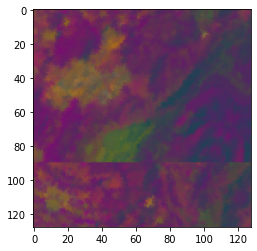

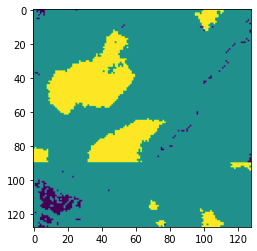

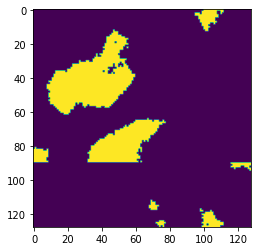

In [ ]:
#check if all the augmented patches having mining pixels have really mining pixels
import random
i = random.randint(0, len(index_of_mining))
j = index_of_mining[i]
plt.imshow(temp_lst_noise[j])
plt.show()
plt.imshow(temp_lst_mask[j])
plt.show()
plt.imshow(temp_lst_mask[j]==2)
plt.show()

In [ ]:
patches_res = np.array(temp_list_image)
patches_mask_res = np.array(temp_lst_mask)
print(patches_res.shape, patches_mask_res.shape)

(17238, 128, 128, 3) (17238, 128, 128)


In [ ]:
#add to the input arrays another dimension for channel 
train_masks = np.expand_dims(patches_mask_res, axis = 3)
train_images = patches_res
np.save('/content/drive/MyDrive/datamining/prisma/Sardinia/totalCustomMaskSea', train_masks)
np.save('/content/drive/MyDrive/datamining/prisma/Sardinia/totalCustomImageSea', train_images)


In [ ]:
########## RESTART KERNEL (RERUN THE LIB AND REINSTALL) #########

In [ ]:
train_masks = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/totalCustomMask.npy')
train_images = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/totalCustomImage.npy')

In [ ]:
#print(train_images.shape, train_masks.shape, np.unique(train_masks))

(29406, 128, 128, 3) (29406, 128, 128, 1) [0 1 2 3]


In [ ]:
from sklearn.model_selection import train_test_split 
X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks, test_size = 0.2, random_state = 0)

In [ ]:
np.save('/content/drive/MyDrive/datamining/prisma/Sardinia/y_train_esaCustomSea', y_train)
np.save('/content/drive/MyDrive/datamining/prisma/Sardinia/y_val_esaCustomSea', y_val)
np.save('/content/drive/MyDrive/datamining/prisma/Sardinia/X_val_esaCustomSea', X_val)
np.save('/content/drive/MyDrive/datamining/prisma/Sardinia/X_train_esaCustomSea', X_train)

In [ ]:
########## RESTART KERNEL (RERUN THE LIB AND REINSTALL) #########

In [ ]:
y_train = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/y_train_esaCustom.npy')
y_val = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/y_val_esaCustom.npy')
X_val = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/X_val_esaCustom.npy')
X_train = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/X_train_esaCustom.npy')

In [ ]:
#print(X_train.shape, X_val.shape, y_train.shape, y_val.shape) 

(23524, 128, 128, 3) (5882, 128, 128, 3) (23524, 128, 128, 1) (5882, 128, 128, 1)


In [ ]:
#print("Class values in the dataset are ... ", np.unique(y_train), np.unique(y_val))

Class values in the dataset are ...  [0 1 2 3] [0 1 2 3]


In [ ]:
from tensorflow.keras.utils import to_categorical
n_classes=4 
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))
val_masks_cat = to_categorical(y_val, num_classes=n_classes)
y_val_cat = val_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))


In [ ]:
np.save('/content/drive/MyDrive/datamining/prisma/Sardinia/y_train_esaCustomCat', y_train_cat)
np.save('/content/drive/MyDrive/datamining/prisma/Sardinia/y_val_esaCustomCat', y_val_cat)

In [ ]:
####### RESTART KERNEL AND SWITCH TO GPU FOR DL RUN ######

In [ ]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib.animation as animation
from matplotlib import rc
import skimage
from skimage.measure import regionprops
import random
import pandas as pd
from skimage import filters
import tifffile as tiff
import tensorflow as tf
import keras
import pickle
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# y_train = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/y_train_esaCustomSea.npy')
# y_val = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/y_val_esaCustomSea.npy')
# X_val = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/X_val_esaCustomSea.npy')
# X_train = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/X_train_esaCustomSea.npy')
# y_train_cat = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/y_train_esaCustomCatSea.npy')
# y_val_cat = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/y_val_esaCustomCatSea.npy')

In [ ]:
y_train = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/y_train_esaCustom.npy')
y_val = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/y_val_esaCustom.npy')
X_val = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/X_val_esaCustom.npy')
X_train = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/X_train_esaCustom.npy')
y_train_cat = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/y_train_esaCustomCat.npy')
y_val_cat = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/y_val_esaCustomCat.npy')

In [ ]:
import segmentation_models as sm
#class_weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
#dice_loss = sm.losses.DiceLoss(class_weights=class_weight_array) 
focal_loss = sm.losses.CategoricalFocalLoss()
#total_loss = dice_loss + (1 * focal_loss)
#jaccard_loss = sm.losses.bce_jaccard_loss(class_weights=class_weight_array)

Segmentation Models: using `keras` framework.


In [ ]:
################################################################ U-NET BUILD ###########################################

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def multi_unet_model(n_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
n_classes=4

In [ ]:
#total_loss= weightedLoss(keras.losses.categorical_crossentropy, class_weights)
model = multi_unet_model(n_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()
monitor = EarlyStopping(monitor= 'val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
import time
checkpointer= ModelCheckpoint(filepath="/content/drive/MyDrive/datamining/prisma/Sardinia/deepUNetEarlyStopEsa200Ep.hdf5", 
                                verbose = 0, save_best_only = True) 
start = time.time()

history = model.fit(X_train, y_train_cat, 
                    batch_size = 32, 
                    verbose=1, 
                    epochs=200, 
                    validation_data=(X_val, y_val_cat), 
                    #sample_weight=class_weight_array,
                    shuffle=False,
                    callbacks=[monitor, checkpointer]
                    )
minutes = (time.time() - start)/60
print("Total model fit time: ", minutes , "minutes")

Epoch 1/200
391/391 [==============================] - 47s 93ms/step - loss: 0.3358 - accuracy: 0.9014 - val_loss: 0.2089 - val_accuracy: 0.9363
Epoch 2/200
391/391 [==============================] - 34s 87ms/step - loss: 0.1644 - accuracy: 0.9469 - val_loss: 0.1561 - val_accuracy: 0.9485
Epoch 3/200
391/391 [==============================] - 34s 88ms/step - loss: 0.1362 - accuracy: 0.9538 - val_loss: 0.1338 - val_accuracy: 0.9549
Epoch 4/200
391/391 [==============================] - 35s 89ms/step - loss: 0.1207 - accuracy: 0.9575 - val_loss: 0.1133 - val_accuracy: 0.9594
Epoch 5/200
391/391 [==============================] - 35s 90ms/step - loss: 0.1109 - accuracy: 0.9599 - val_loss: 0.1103 - val_accuracy: 0.9606
Epoch 6/200
391/391 [==============================] - 35s 90ms/step - loss: 0.1051 - accuracy: 0.9616 - val_loss: 0.0996 - val_accuracy: 0.9634
Epoch 7/200
391/391 [==============================] - 35s 90ms/step - loss: 0.1000 - accuracy: 0.9630 - val_loss: 0.0953 - val_ac

In [ ]:
#model.save('/content/drive/MyDrive/datamining/prisma/Sardinia/deepUNet200EpCustomEsa')
#model.save('/content/drive/MyDrive/datamining/prisma/Sardinia/deepUNet600EpCustomEsa')

In [ ]:
model_saved =  keras.models.load_model('/content/drive/MyDrive/datamining/prisma/Sardinia/deepUNetEarlyStopEsa200Ep.hdf5',compile=False)
#model_saved =  keras.models.load_model('/content/drive/MyDrive/datamining/prisma/Sardinia/deepUNetEarlyStopEsaSea.hdf5',compile=False)


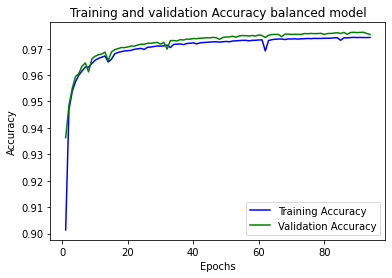

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Training and validation Accuracy balanced model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#prediction = model.predict(X_val)
prediction = model_saved.predict(X_val)

98/98 [==============================] - 11s 106ms/step


PREDICTION


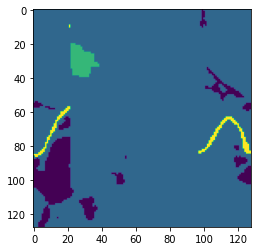

[0 1 2 3]
GROUND TRUTH


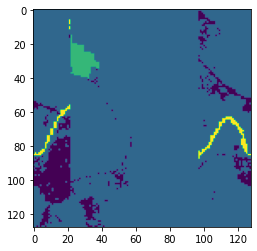

[0 1 2 3]


In [ ]:
import random
i = random.randint(0, prediction.shape[0])
predicted_img=np.argmax(prediction, axis=3)[i,:,:]
print("PREDICTION")
plt.imshow(predicted_img)
plt.show()
print(np.unique(predicted_img))
print("GROUND TRUTH")
plt.imshow(y_val[i,:,:,0])
plt.show()
print(np.unique(y_val[i,:,:,0]))

In [ ]:
#IOU
y_pred=prediction
y_pred_argmax=np.argmax(y_pred, axis=3)

In [ ]:
##################################################

#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_val, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])
#class5_IoU = values[4,4]/(values[4,4] + values[4,0] + values[4,1] + values[4,2] + values[0,4]+ values[1,4]+ values[2,4])
#class6_IoU = values[5,5]/(values[5,5] + values[5,0] + values[5,1] + values[5,2] + values[0,5]+ values[1,5]+ values[2,5])

print("IoU for build up is: ", class1_IoU)
print("IoU for veg area: ", class2_IoU)
#print("IoU for sparse veg is: ", class3_IoU)
print("IoU for mining area is: ", class3_IoU)
print("IoU for water is: ", class4_IoU)
#print("IoU for urban area is: ", class6_IoU)


#plt.imshow(train_images[0, :,:,0], cmap='gray')
#plt.imshow(train_masks[0, :,:,0], cmap='gray')
#######################################################################

Mean IoU = 0.84859407
[[1.2455560e+06 6.3704600e+05 1.1890000e+03 1.6330000e+03]
 [2.5805400e+05 1.6777216e+07 8.7442000e+04 7.7908000e+04]
 [5.7000000e+02 7.7696000e+04 1.9454070e+06 3.7100000e+02]
 [6.2200000e+02 7.5682000e+04 3.4600000e+02 3.7971310e+06]]
IoU for build up is:  0.5807681
IoU for veg area:  0.93253154
IoU for mining area is:  0.92067564
IoU for water is:  0.96040106


In [ ]:
####### BRAZIL TEST SET ######## ##### restart kernel e reimport lib and reinstall #####

In [ ]:
#model_saved =  keras.models.load_model('/content/drive/MyDrive/datamining/prisma/Sardinia/deepUNet200EpCustomEsa',compile=False)


In [ ]:
print(brazil_image.shape, brazil_mask.shape)

(950, 950, 181) (950, 950)


In [ ]:
#brazil_mask_cut = brazil_mask[0:600, 250:600]
#brazil_cut = brazil_image[0:600, 250:600]

In [ ]:
brazil_mask_test = brazil_mask[:, 600:950]
brazil_test = brazil_image[:, 600:950]
brazil_mask_test2 = brazil_mask[600:950, :]
brazil_test2 = brazil_image[600:950, :]

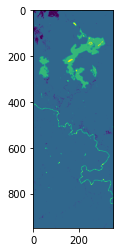

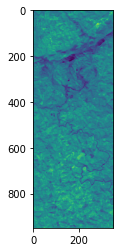

(950, 350, 181)


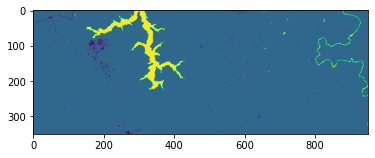

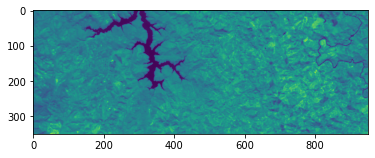

(950, 350, 181)


In [ ]:
plt.imshow(brazil_mask_test)
plt.show()
plt.imshow(brazil_test[:,:,50])
plt.show()
print(brazil_test.shape)
plt.imshow(brazil_mask_test2)
plt.show()
plt.imshow(brazil_test2[:,:,50])
plt.show()
print(brazil_test.shape)

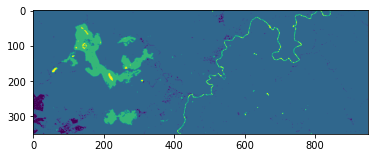

(350, 950)


In [ ]:
brazil_mask_test_rot =  np.rot90(brazil_mask_test)
plt.imshow(brazil_mask_test_rot)
plt.show()
print(brazil_mask_test_rot.shape)

In [ ]:
lst = []
for i in range (brazil_test.shape[2]):
  rot =  np.rot90(brazil_test[:,:,i])
  lst.append(rot)
brazil_test_rot = np.array(lst)

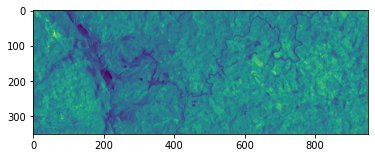

In [ ]:
plt.imshow(brazil_test_rot[50,:,:])
plt.show()

In [ ]:
brazil_test_rot.shape
brazil_test_rot = reshape_as_image(brazil_test_rot)
brazil_test_rot.shape

(350, 950, 181)

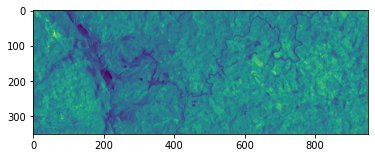

In [ ]:
plt.imshow(brazil_test_rot[:,:,50])
plt.show()

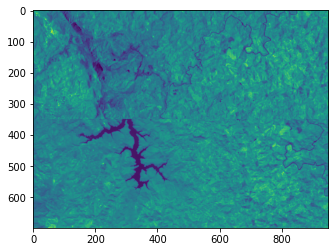

In [ ]:
brazil_tot = np.concatenate((brazil_test_rot, brazil_test2), axis = 0)
plt.imshow(brazil_tot[:,:,50])
plt.show()

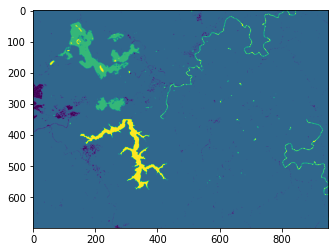

In [ ]:
brazil_mask_tot = np.concatenate((brazil_mask_test_rot, brazil_mask_test2), axis = 0)
plt.imshow(brazil_mask_tot)
plt.show()

In [ ]:
#build the 2d array for svd
svd_cube = np.reshape(brazil_tot, (brazil_tot.shape[0]*brazil_tot.shape[1], brazil_tot.shape[2]))
svd_cube.shape

(665000, 181)

In [ ]:
import pickle
loaded_model = pickle.load(open('/content/drive/MyDrive/datamining/prisma/Sardinia/SvdFullCustomImage.sav', 'rb'))
total_transf_cube = loaded_model.transform(svd_cube)

In [ ]:
print(np.max(total_transf_cube), np.min(total_transf_cube))

5.349729 -1.0730457


In [ ]:
loaded_norm = pickle.load(open('/content/drive/MyDrive/datamining/prisma/Sardinia/NormalizaFullCustomImage.sav', 'rb'))
total_transf_cube = loaded_norm.transform(total_transf_cube)


In [ ]:
print(np.min(total_transf_cube), np.max(total_transf_cube))


-0.069860265 0.93430007


In [ ]:
#after the svd transformation, reshape the array as an 3D image 
svd_array = np.reshape(total_transf_cube, (brazil_tot.shape[0],brazil_tot.shape[1],total_transf_cube.shape[1]))
print(svd_array.shape, brazil_tot.shape)


(700, 950, 3) (700, 950, 181)


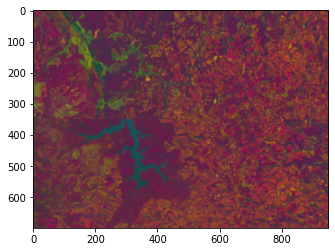

In [ ]:
plt.imshow(svd_array)
plt.show()

In [ ]:
# divide the image in non overlapping pathces
patches = patchify.patchify(svd_array, (128,128,3), step = 128)

In [ ]:
patches_res = patches.reshape(patches.shape[0] * patches.shape[1], patches.shape[3], patches.shape[4], patches.shape[5])
#patches_res2 = patches2.reshape(patches2.shape[0] * patches2.shape[1], patches2.shape[3], patches2.shape[4], patches2.shape[5])

In [ ]:
prediction = model_saved.predict(patches_res)


2/2 [==============================] - 0s 28ms/step


In [ ]:
predict = []
for i in range (prediction.shape[0]):
  predicted_img=np.argmax(prediction, axis=3)[i,:,:]
  predict.append(predicted_img)
prd = np.array(predict)

In [ ]:
#divide the mask in non overlapping patches
patches_mask = patchify.patchify(brazil_mask_tot, (128,128), step = 128)

In [ ]:
patches_mask_res = patches_mask.reshape(patches_mask.shape[0] * patches_mask.shape[1], patches_mask.shape[2], patches_mask.shape[3])


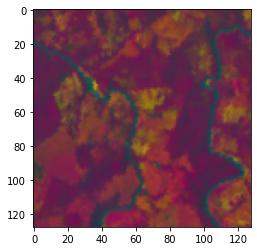

5  the minimum is  0.04103282
GROUND TRUTH


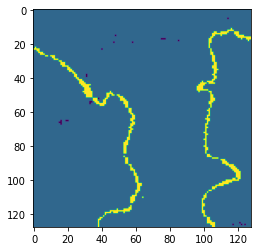

[0 1 3]
PREDICTION


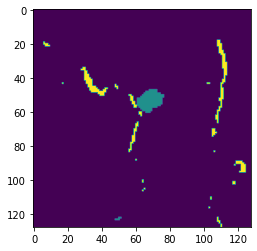

[1 2 3]


In [ ]:
import random
i = random.randint(0, 14)
plt.imshow(patches_res[i])
plt.show()
print(i, " the minimum is ", np.min(patches_res[i]))
print("GROUND TRUTH")
plt.imshow(patches_mask_res[i])
plt.show()
print(np.unique(patches_mask_res[i]))
print("PREDICTION")
plt.imshow(prd[i])
plt.show()
print(np.unique(prd[i]))

In [ ]:
##################################################
#### first brazil area ########
#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(patches_mask_res, prd)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])
#class5_IoU = values[4,4]/(values[4,4] + values[4,0] + values[4,1] + values[4,2] + values[0,4]+ values[1,4]+ values[2,4])
#class6_IoU = values[5,5]/(values[5,5] + values[5,0] + values[5,1] + values[5,2] + values[0,5]+ values[1,5]+ values[2,5])

print("IoU for build up is: ", class1_IoU)
print("IoU for veg area: ", class2_IoU)
#print("IoU for sparse veg is: ", class3_IoU)
print("IoU for mining area is: ", class3_IoU)
print("IoU for water is: ", class4_IoU)
#print("IoU for urban area is: ", class6_IoU)


#plt.imshow(train_images[0, :,:,0], cmap='gray')
#plt.imshow(train_masks[0, :,:,0], cmap='gray')
#######################################################################

Mean IoU = 0.5027424
[[1.93700e+03 4.72100e+03 8.00000e+01 1.60000e+01]
 [2.05000e+03 5.30112e+05 4.83600e+03 2.36200e+03]
 [2.09000e+02 8.89300e+03 5.82900e+03 6.40000e+01]
 [2.00000e+00 3.91300e+03 2.22000e+02 8.19400e+03]]
IoU for build up is:  0.21486412
IoU for veg area:  0.9519202
IoU for mining area is:  0.28952467
IoU for water is:  0.55466056


In [ ]:
print(prd.shape, brazil_mask_tot.shape)
bazil_prd_patches = prd.reshape(5,7,128,128)


(35, 128, 128) (700, 950)


In [ ]:
print(700/128)
print(950/128)

5.46875
7.421875


In [ ]:
from patchify import unpatchify 
unpatched_prediction = unpatchify(bazil_prd_patches, (5*128, 7*128))

In [ ]:
unpatched_prediction.shape

(640, 896)

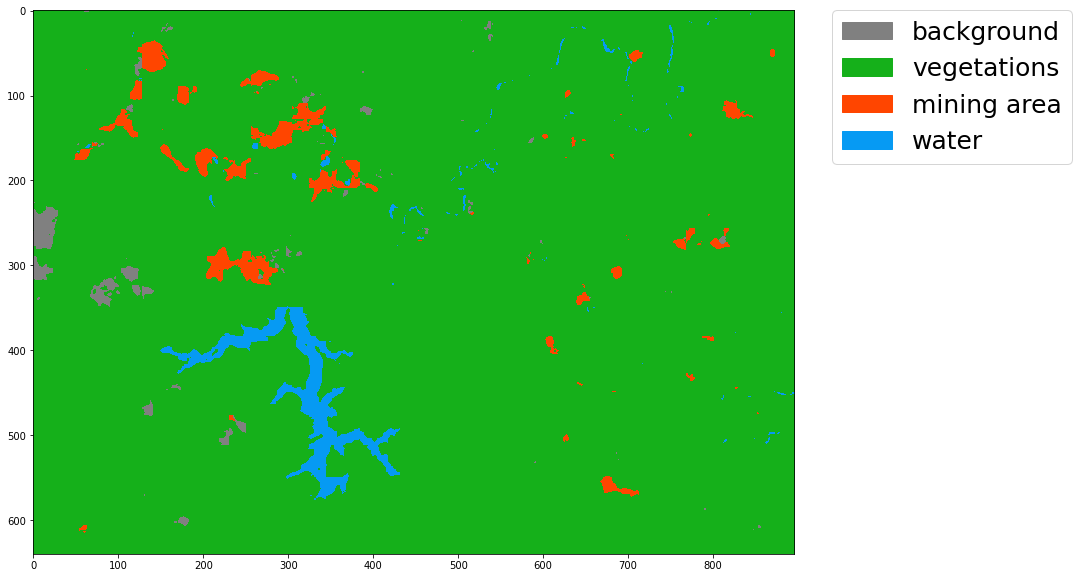

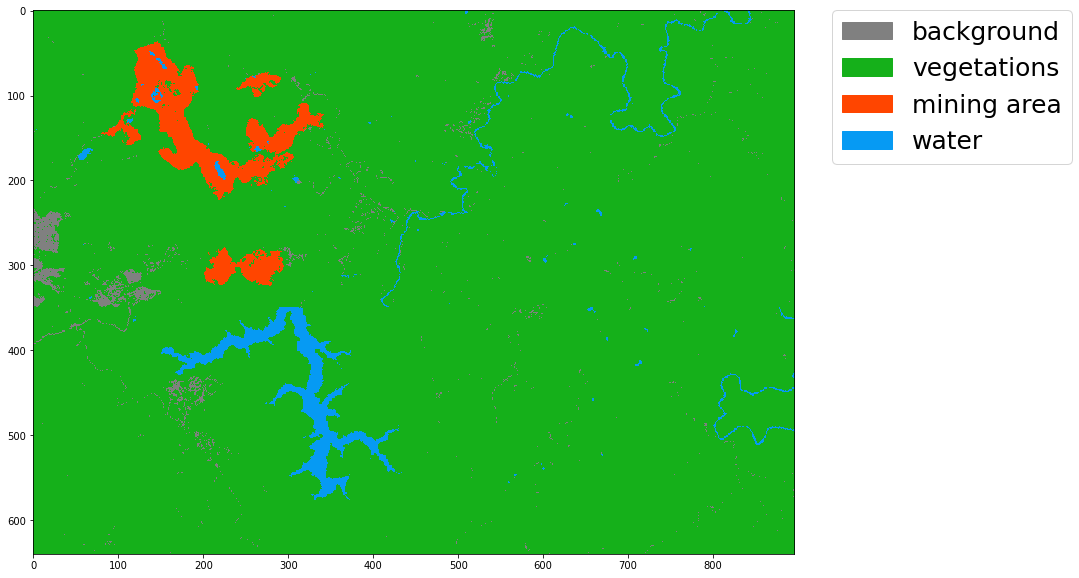

In [ ]:
import matplotlib.patches as mpatches
## PLOT BRAZIL PREDICTION
values = np.unique(unpatched_prediction)
label = ["background", "vegetations","mining area", "water"]
colors = ['gray', '#15B01A', '#FF4500', '#069AF3']
bounds = [0,1,2,3,4]
cmap = matplotlib.colors.ListedColormap(colors)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
plt.figure(figsize=(20,10))
im_gr_tr = plt.imshow(unpatched_prediction, interpolation='none', cmap=cmap, norm=norm)
#plt.figure(figsize=(24,12))
colors = [im_gr_tr.cmap(im_gr_tr.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=label[i])  for i in range(len(values))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2,  prop={'size': 25}, borderaxespad=0. )
#plt.savefig("/content/drive/MyDrive/datamining/prisma/Brazil/PredictionNew.pdf", format = 'pdf', bbox_inches='tight')
#plt.savefig("/content/drive/MyDrive/datamining/prisma/Brazil/PredictionNew.png", format = 'png', bbox_inches='tight')

plt.show()


import matplotlib.patches as mpatches
## PLOT BRAZIL GT
values = np.unique(brazil_mask_tot)
label = ["background", "vegetations","mining area", "water"]
colors = ['gray', '#15B01A', '#FF4500', '#069AF3']
bounds = [0,1,2,3,4]
cmap = matplotlib.colors.ListedColormap(colors)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
plt.figure(figsize=(20,10))
im_gr_tr = plt.imshow(brazil_mask_tot[0:640, 0:896], interpolation='none', cmap=cmap, norm=norm)
#plt.figure(figsize=(24,12))
colors = [im_gr_tr.cmap(im_gr_tr.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=label[i])  for i in range(len(values))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2,  prop={'size': 25}, borderaxespad=0. )
#plt.savefig("/content/drive/MyDrive/datamining/prisma/Brazil/PredictionNew.pdf", format = 'pdf', bbox_inches='tight')
#plt.savefig("/content/drive/MyDrive/datamining/prisma/Brazil/PredictionNew.png", format = 'png', bbox_inches='tight')

plt.show()



In [ ]:
#brazil_mask_tot